
**Student: Akshay Javagal Somashekhar (120221054)**

By submitting this exam, I declare

(1) that all work of it is my own;

(2) that I did not seek whole or partial solutions for any part of my submission from others; and

(3) that I did not and will not discuss, exchange, share, or publish complete or partial solutions for this exam or any part of it.

## Setup
We start by importing the libraries and functions that we will need.

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals


import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.datasets import mnist

print('TensorFlow version:', tf.__version__)
print('Is Executing Eagerly?', tf.executing_eagerly())

TensorFlow version: 2.4.1
Is Executing Eagerly? True


## Pre-Process the dataset

1. Import the dataset.
2. normalize the pixel values for each example through dividing by maximum pixel value.
3. We shall flatten the examples from 28 by 28 arrays to 784-dimensional vectors.

In [ ]:
from tensorflow.keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype(np.float32) /255
x_test = x_test.astype(np.float32) /255

x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))

training_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(256)

## Baseline Model:

Checking the performance for the given baseline model:


*   Encoder class: Dense layers as hidden and output encoding layer.
*   Decoder class: Dense layers as hidden and output decoding layer.
*   Both classes ReLu activators in their respective layers.
*   Input image is compressed to a image of 'intermediate_dim' by the encoder and the compressed image is decoded back to 'original_dim'
*   Loss Computation/ Recontruction loss: Mean Squared error is considered as the metric
*   Optimizer: Adam Optimizer with learning rate of 0.01



Epoch 1/20. Loss: 7.997819900512695
Epoch 2/20. Loss: 4.898742198944092
Epoch 3/20. Loss: 4.33286714553833
Epoch 4/20. Loss: 4.045149803161621
Epoch 5/20. Loss: 3.882871150970459
Epoch 6/20. Loss: 3.763767719268799
Epoch 7/20. Loss: 3.6832478046417236
Epoch 8/20. Loss: 3.6064391136169434
Epoch 9/20. Loss: 3.54673433303833
Epoch 10/20. Loss: 3.5447652339935303
Epoch 11/20. Loss: 3.4683218002319336
Epoch 12/20. Loss: 3.4513156414031982
Epoch 13/20. Loss: 3.4102425575256348
Epoch 14/20. Loss: 3.4081101417541504
Epoch 15/20. Loss: 3.406994342803955
Epoch 16/20. Loss: 3.401144504547119
Epoch 17/20. Loss: 3.3643221855163574
Epoch 18/20. Loss: 3.3539347648620605
Epoch 19/20. Loss: 3.38822078704834
Epoch 20/20. Loss: 3.350022554397583


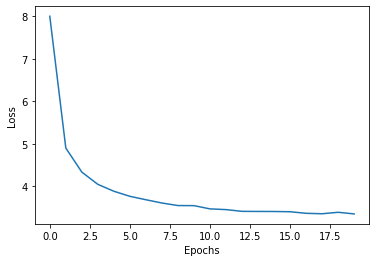

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
    
    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return self.output_layer(activation)
        
class Decoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim, original_dim):
        super(Decoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=original_dim, activation=tf.nn.relu)
  
    def call(self, code):
        activation = self.hidden_layer(code)
        return self.output_layer(activation)

class Autoencoder(tf.keras.Model):
  def __init__(self, intermediate_dim, original_dim):
    super(Autoencoder, self).__init__()
    self.loss = []
    self.encoder = Encoder(intermediate_dim=intermediate_dim)
    self.decoder = Decoder(intermediate_dim=intermediate_dim, original_dim=original_dim)

  def call(self, input_features):
    code = self.encoder(input_features)
    reconstructed = self.decoder(code)
    return reconstructed

# Reconstruction error
def loss(preds, real):
  return tf.reduce_mean(tf.square(tf.subtract(preds, real)))
  
def train(loss, model, opt, original):
  with tf.GradientTape() as tape:
    preds = model(original)
    reconstruction_error = loss(preds, original)
  gradients = tape.gradient(reconstruction_error, model.trainable_variables)
  gradient_variables = zip(gradients, model.trainable_variables)
  opt.apply_gradients(gradient_variables)
  
  return reconstruction_error

def train_loop(model, opt, loss, dataset, epochs):
  for epoch in range(epochs):
    epoch_loss = 0
    for step, batch_features in enumerate(dataset):
      loss_values = train(loss, model, opt, batch_features)
      epoch_loss += loss_values
    model.loss.append(epoch_loss)
    print('Epoch {}/{}. Loss: {}'.format(epoch + 1, epochs, epoch_loss.numpy()))

model = Autoencoder(intermediate_dim=128, original_dim=784)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

train_loop(model, opt, loss, training_dataset, 20)

plt.plot(range(20), model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

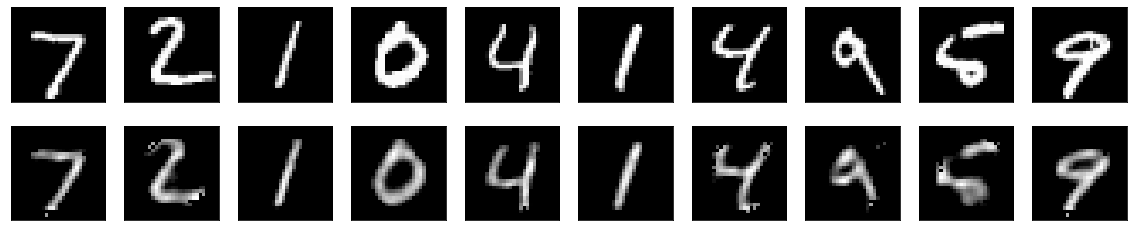

In [ ]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**Evaluation**: 
1. Original Image/reconstructed image sizeCompressed Image size: 128 (given) 
2. Model loss is stable at 5.3 after completing 20 epochs.
3. Reconstructed Images are blurry indicating loss of details.



## 1. Basic Autoencoder Performance Optimization



### 1.1 Build 3 different auto encoders based on dense layers

**Dense Architecture Change 1**:
One extra Dense layer (for both encoder and decoder) is added to improve the reconstruction loss

In [ ]:
# Encoder layer
class Encoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim):
        super(Encoder, self).__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256, activation=tf.nn.relu)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
    
    def call(self, input_features):
        intermediate = self.hidden_layer_1(input_features)
        activation = self.hidden_layer_2(intermediate)
        return self.output_layer(activation)

# Decoder layer        
class Decoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim, original_dim):
        super(Decoder, self).__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=256, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=original_dim, activation=tf.nn.relu)
  
    def call(self, code):
        intermediate = self.hidden_layer_1(code)
        activation = self.hidden_layer_2(intermediate)
        return self.output_layer(activation)

class Autoencoder(tf.keras.Model):
  def __init__(self, intermediate_dim, original_dim):
    super(Autoencoder, self).__init__()
    self.loss = []
    self.encoder = Encoder(intermediate_dim=intermediate_dim)
    self.decoder = Decoder(intermediate_dim=intermediate_dim, original_dim=original_dim)

  def call(self, input_features):
    code = self.encoder(input_features)
    reconstructed = self.decoder(code)
    return reconstructed

# Forward pass and optimization
def train(loss, model, opt, original):
  with tf.GradientTape() as tape:
    preds = model(original)
    reconstruction_error = loss(preds, original)
  gradients = tape.gradient(reconstruction_error, model.trainable_variables)
  gradient_variables = zip(gradients, model.trainable_variables)
  opt.apply_gradients(gradient_variables)
  
  return reconstruction_error

# The training loop
def train_loop(model, opt, loss, dataset, epochs):
  for epoch in range(epochs):
    epoch_loss = 0
    for step, batch_features in enumerate(dataset):
      loss_values = train(loss, model, opt, batch_features)
      epoch_loss += loss_values
    model.loss.append(epoch_loss)
    print('Epoch {}/{}. Loss: {}'.format(epoch + 1, epochs, epoch_loss.numpy()))

In [ ]:
model = Autoencoder(intermediate_dim=128, original_dim=784)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

train_loop(model, opt, loss, training_dataset, 20)

Epoch 1/20. Loss: 14.070197105407715
Epoch 2/20. Loss: 6.757962226867676
Epoch 3/20. Loss: 5.795591354370117
Epoch 4/20. Loss: 5.347397327423096
Epoch 5/20. Loss: 4.982280731201172
Epoch 6/20. Loss: 4.762223720550537
Epoch 7/20. Loss: 4.581704139709473
Epoch 8/20. Loss: 4.505699157714844
Epoch 9/20. Loss: 4.348604679107666
Epoch 10/20. Loss: 4.277479648590088
Epoch 11/20. Loss: 4.156033039093018
Epoch 12/20. Loss: 4.121856689453125
Epoch 13/20. Loss: 3.9852449893951416
Epoch 14/20. Loss: 3.995560646057129
Epoch 15/20. Loss: 3.862759590148926
Epoch 16/20. Loss: 3.8834736347198486
Epoch 17/20. Loss: 3.791189432144165
Epoch 18/20. Loss: 3.7809176445007324
Epoch 19/20. Loss: 3.79664945602417
Epoch 20/20. Loss: 3.7489705085754395


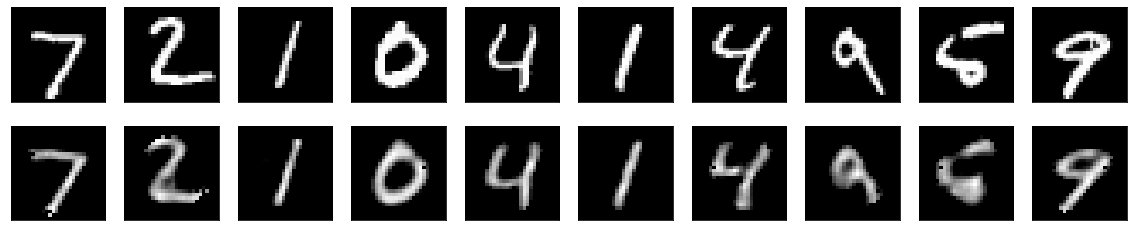

In [ ]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**Evaluation**: 
1. There's not much change observed in the model. 
2. Reconstruction loss is reduced by little amount (stable at 4.3%) and images are still blurry.

**Dense Architecture Change 2**: Changing the output layer activation layer to sigmoid activation

In [ ]:
# Encoder layer
class Encoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(intermediate_dim, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
    
    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return self.output_layer(activation)

# Decoder layer        
class Decoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim, original_dim):
        super(Decoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(intermediate_dim, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=original_dim, activation=tf.nn.sigmoid)
  
    def call(self, code):
        activation = self.hidden_layer(code)
        return self.output_layer(activation)

class Autoencoder(tf.keras.Model):
  def __init__(self, intermediate_dim, original_dim):
    super(Autoencoder, self).__init__()
    self.loss = []
    self.encoder = Encoder(intermediate_dim=intermediate_dim)
    self.decoder = Decoder(intermediate_dim=intermediate_dim, original_dim=original_dim)

  def call(self, input_features):
    code = self.encoder(input_features)
    reconstructed = self.decoder(code)
    return reconstructed

# Forward pass and optimization
def train(loss, model, opt, original):
  with tf.GradientTape() as tape:
    preds = model(original)
    reconstruction_error = loss(preds, original)
  gradients = tape.gradient(reconstruction_error, model.trainable_variables)
  gradient_variables = zip(gradients, model.trainable_variables)
  opt.apply_gradients(gradient_variables)
  
  return reconstruction_error

# The training loop
def train_loop(model, opt, loss, dataset, epochs):
  for epoch in range(epochs):
    epoch_loss = 0
    for step, batch_features in enumerate(dataset):
      loss_values = train(loss, model, opt, batch_features)
      epoch_loss += loss_values
    model.loss.append(epoch_loss)
    print('Epoch {}/{}. Loss: {}'.format(epoch + 1, epochs, epoch_loss.numpy()))

In [ ]:
model = Autoencoder(intermediate_dim=128, original_dim=784)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

train_loop(model, opt, loss, training_dataset, 20)

Epoch 1/20. Loss: 9.5928955078125
Epoch 2/20. Loss: 4.046403408050537
Epoch 3/20. Loss: 3.0647621154785156
Epoch 4/20. Loss: 2.6273369789123535
Epoch 5/20. Loss: 2.3717002868652344
Epoch 6/20. Loss: 2.182307720184326
Epoch 7/20. Loss: 2.0729687213897705
Epoch 8/20. Loss: 1.9590681791305542
Epoch 9/20. Loss: 1.8721723556518555
Epoch 10/20. Loss: 1.8144651651382446
Epoch 11/20. Loss: 1.7672479152679443
Epoch 12/20. Loss: 1.7184525728225708
Epoch 13/20. Loss: 1.689525842666626
Epoch 14/20. Loss: 1.6666876077651978
Epoch 15/20. Loss: 1.6580426692962646
Epoch 16/20. Loss: 1.6376338005065918
Epoch 17/20. Loss: 1.6119327545166016
Epoch 18/20. Loss: 1.5918077230453491
Epoch 19/20. Loss: 1.5680675506591797
Epoch 20/20. Loss: 1.5707155466079712


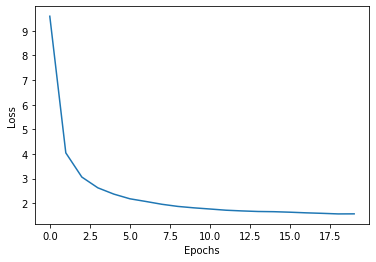

In [ ]:
plt.plot(range(20), model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

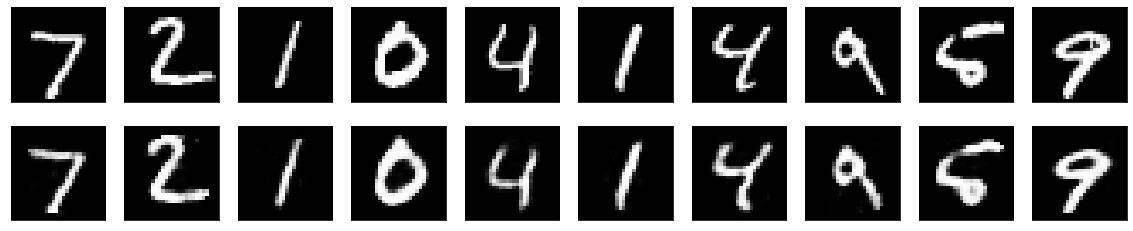

In [ ]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**Checking for furthur compression loss**

In [ ]:
model = Autoencoder(intermediate_dim=32, original_dim=784)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

train_loop(model, opt, loss, training_dataset, 20)

Epoch 1/20. Loss: 11.47204303741455
Epoch 2/20. Loss: 6.364501953125
Epoch 3/20. Loss: 5.3606953620910645
Epoch 4/20. Loss: 5.02986478805542
Epoch 5/20. Loss: 4.868656158447266
Epoch 6/20. Loss: 4.77023458480835
Epoch 7/20. Loss: 4.705783843994141
Epoch 8/20. Loss: 4.652875900268555
Epoch 9/20. Loss: 4.6166157722473145
Epoch 10/20. Loss: 4.589623928070068
Epoch 11/20. Loss: 4.56156587600708
Epoch 12/20. Loss: 4.533804893493652
Epoch 13/20. Loss: 4.508186340332031
Epoch 14/20. Loss: 4.489125728607178
Epoch 15/20. Loss: 4.480985164642334
Epoch 16/20. Loss: 4.472590923309326
Epoch 17/20. Loss: 4.4655232429504395
Epoch 18/20. Loss: 4.459381580352783
Epoch 19/20. Loss: 4.449448108673096
Epoch 20/20. Loss: 4.445565700531006


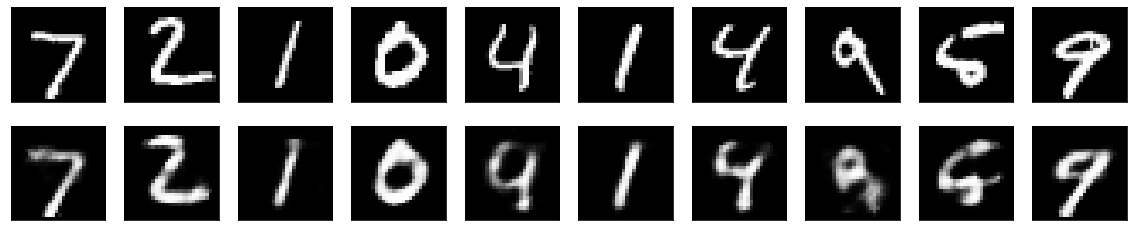

In [ ]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**Evaluation:**
1. Activation function change: Decoder output layer's activation layer was changed to sigmoid. 
2. Loss reduced by 2.8% when compared to baseline architecture.
3. Reconstructed image is more clearer now.
4. Trying for furthur Compression: Compressed image size - 32; Reconstruction loss is also very less and is stable at 4.1%. This model performs better than baseline architecture with even more compression ratio.

**Dense Architecture Change 3**: Adding a sparsity constraint on the encoded representations

In [ ]:
# Encoder layer
from keras import regularizers
class Encoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units = intermediate_dim, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units = intermediate_dim, activation=tf.nn.relu, activity_regularizer = regularizers.l1(10e-5))
    
    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return self.output_layer(activation)

# Decoder layer        
class Decoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim, original_dim):
        super(Decoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units = intermediate_dim, activation = tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units = original_dim, activation = tf.nn.sigmoid)
  
    def call(self, code):
        activation = self.hidden_layer(code)
        return self.output_layer(activation)

class Autoencoder(tf.keras.Model):
  def __init__(self, intermediate_dim, original_dim):
    super(Autoencoder, self).__init__()
    self.loss = []
    self.encoder = Encoder(intermediate_dim=intermediate_dim)
    self.decoder = Decoder(intermediate_dim=intermediate_dim, original_dim=original_dim)

  def call(self, input_features):
    code = self.encoder(input_features)
    reconstructed = self.decoder(code)
    return reconstructed
# Reconstruction error
def loss(preds, real):
  return tf.reduce_mean(tf.square(tf.subtract(preds, real)))
# Forward pass and optimization
def train(loss, model, opt, original):
  with tf.GradientTape() as tape:
    preds = model(original)
    reconstruction_error = loss(preds, original)
  gradients = tape.gradient(reconstruction_error, model.trainable_variables)
  gradient_variables = zip(gradients, model.trainable_variables)
  opt.apply_gradients(gradient_variables)
  
  return reconstruction_error

# The training loop
def train_loop(model, opt, loss, dataset, epochs):
  for epoch in range(epochs):
    epoch_loss = 0
    for step, batch_features in enumerate(dataset):
      loss_values = train(loss, model, opt, batch_features)
      epoch_loss += loss_values
    model.loss.append(epoch_loss)
    print('Epoch {}/{}. Loss: {}'.format(epoch + 1, epochs, epoch_loss.numpy()))

In [ ]:
model = Autoencoder(intermediate_dim=128, original_dim=784)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

train_loop(model, opt, loss, training_dataset, 20)

Epoch 1/20. Loss: 9.571773529052734
Epoch 2/20. Loss: 4.087284088134766
Epoch 3/20. Loss: 3.0539588928222656
Epoch 4/20. Loss: 2.591529130935669
Epoch 5/20. Loss: 2.358696699142456
Epoch 6/20. Loss: 2.233485698699951
Epoch 7/20. Loss: 2.0711605548858643
Epoch 8/20. Loss: 1.977226972579956
Epoch 9/20. Loss: 1.89313805103302
Epoch 10/20. Loss: 1.8411728143692017
Epoch 11/20. Loss: 1.8119667768478394
Epoch 12/20. Loss: 1.7729740142822266
Epoch 13/20. Loss: 1.737683653831482
Epoch 14/20. Loss: 1.7458171844482422
Epoch 15/20. Loss: 1.7228909730911255
Epoch 16/20. Loss: 1.690755844116211
Epoch 17/20. Loss: 1.6700518131256104
Epoch 18/20. Loss: 1.664983868598938
Epoch 19/20. Loss: 1.6464327573776245
Epoch 20/20. Loss: 1.621361255645752


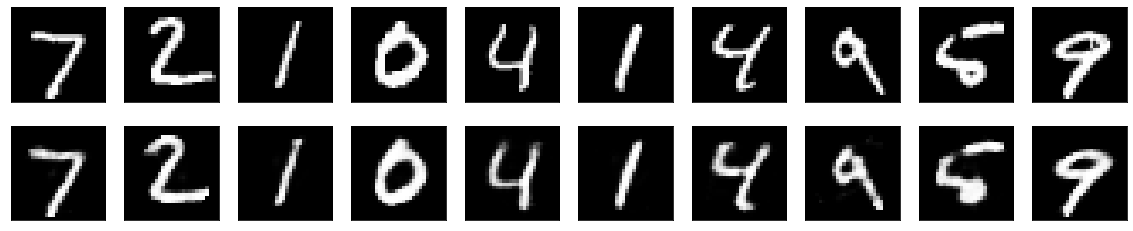

In [ ]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**Evaluation:**

1. Sparsity is introduced to Encoding layer to boost the hidden units of Dense layer.
2. This has significantly improved the clarity of reconstructed image.
3. Reconstruction loss is stable at 1.5%.

### 1.2 Define 2 CNN architectures

In [ ]:
# to train this model we will with original MNIST digits with shape (samples, 3, 28, 28) and we will just normalize pixel values between 0 and 1
# (x_train, _), (x_test, _) = load_data('../input/mnist.npz')
from tensorflow.keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

**CNN architecture 1**: 

In [ ]:
input_img = tf.keras.layers.Input(shape=(28, 28, 1)) # adapt this if using `channels_first` image data format

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 4, 4, 8)           0  

In [ ]:
autoencoder.fit(x_train, x_train, epochs=50, batch_size=128, 
                shuffle=True, validation_data=(x_test, x_test),)

Epoch 1/50
469/469 [==============================] - 4s 6ms/step - loss: 0.2997 - val_loss: 0.1464
Epoch 2/50
469/469 [==============================] - 3s 5ms/step - loss: 0.1413 - val_loss: 0.1280
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1263 - val_loss: 0.1194
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1188 - val_loss: 0.1136
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1137 - val_loss: 0.1094
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1097 - val_loss: 0.1069
Epoch 7/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1073 - val_loss: 0.1046
Epoch 8/50
469/469 [==============================] - 3s 5ms/step - loss: 0.1055 - val_loss: 0.1032
Epoch 9/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1038 - val_loss: 0.1015
Epoch 10/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1026 - val_loss: 0.1008

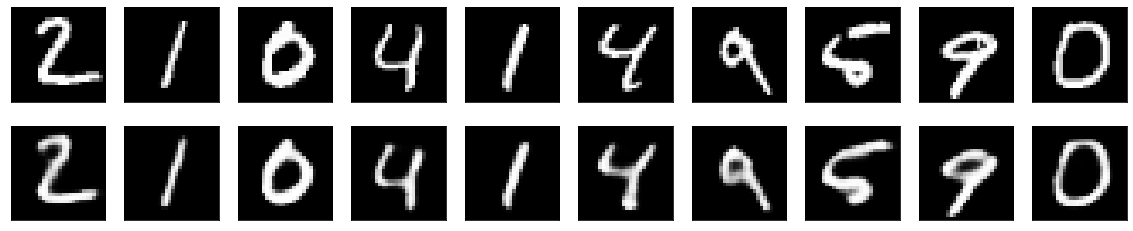

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**CNN Architecture Change 1**: Adding L1 regularizer to add more sparsity

In [ ]:
input_img = tf.keras.layers.Input(shape=(28, 28, 1)) # adapt this if using `channels_first` image data format

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same',kernel_regularizer =tf.keras.regularizers.l1( l=10e-5))(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same',kernel_regularizer =tf.keras.regularizers.l1( l=10e-5))(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same',kernel_regularizer =tf.keras.regularizers.l1( l=10e-5))(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train, epochs=50, batch_size=128, 
                shuffle=True, validation_data=(x_test, x_test))

Epoch 1/50
469/469 [==============================] - 3s 6ms/step - loss: 0.3268 - val_loss: 0.1587
Epoch 2/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1532 - val_loss: 0.1392
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1374 - val_loss: 0.1297
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1291 - val_loss: 0.1243
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1238 - val_loss: 0.1211
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1204 - val_loss: 0.1168
Epoch 7/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1175 - val_loss: 0.1147
Epoch 8/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1151 - val_loss: 0.1126
Epoch 9/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1133 - val_loss: 0.1112
Epoch 10/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1119 - val_loss: 0.1094

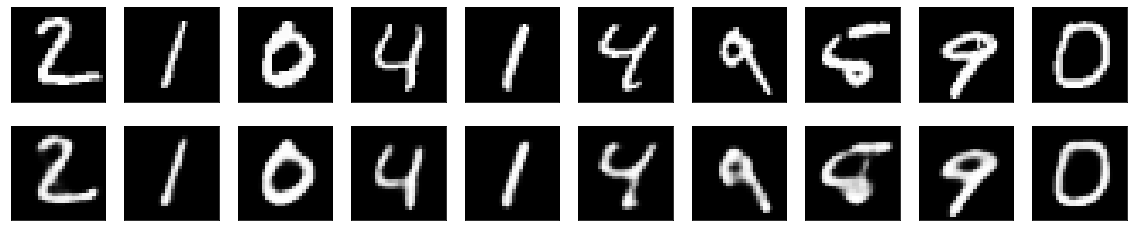

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**CNN Architecture Change 2**: Adding L2 regularizer to add more sparsity

In [ ]:
input_img = tf.keras.layers.Input(shape=(28, 28, 1)) # adapt this if using `channels_first` image data format

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same',kernel_regularizer = tf.keras.regularizers.l2( l=10e-5))(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same',kernel_regularizer =tf.keras.regularizers.l2( l=10e-5))(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same',kernel_regularizer =tf.keras.regularizers.l2( l=10e-5))(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train, epochs=50, batch_size=128, 
                shuffle=True, validation_data=(x_test, x_test))

Epoch 1/50
469/469 [==============================] - 4s 6ms/step - loss: 0.2999 - val_loss: 0.1485
Epoch 2/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1426 - val_loss: 0.1262
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1248 - val_loss: 0.1183
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1176 - val_loss: 0.1134
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1132 - val_loss: 0.1096
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1100 - val_loss: 0.1072
Epoch 7/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1079 - val_loss: 0.1052
Epoch 8/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1059 - val_loss: 0.1034
Epoch 9/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1041 - val_loss: 0.1021
Epoch 10/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1031 - val_loss: 0.1006

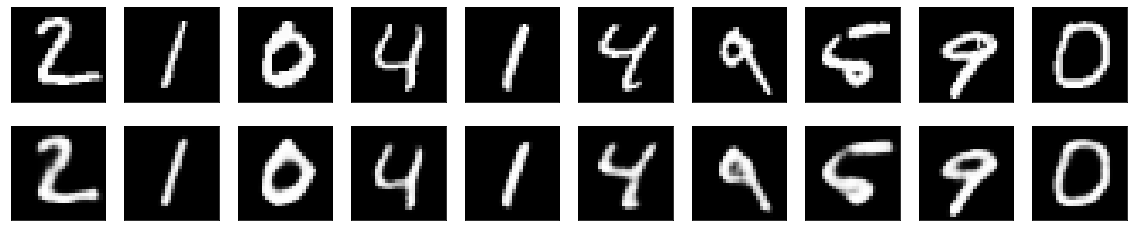

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**CNN Architecture Change 3**: Remove a Max pool layer

In [ ]:
input_img = tf.keras.layers.Input(shape=(28, 28, 1)) # adapt this if using `channels_first` image data format

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same',kernel_regularizer = tf.keras.regularizers.l2( l=10e-5))(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same',kernel_regularizer =tf.keras.regularizers.l2( l=10e-5))(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same',kernel_regularizer =tf.keras.regularizers.l2( l=10e-5))(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train, epochs=50, batch_size=128, 
                shuffle=True, validation_data=(x_test, x_test))

Epoch 1/50
469/469 [==============================] - 4s 6ms/step - loss: 0.3308 - val_loss: 0.1500
Epoch 2/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1455 - val_loss: 0.1321
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1308 - val_loss: 0.1233
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1233 - val_loss: 0.1182
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1185 - val_loss: 0.1146
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1147 - val_loss: 0.1120
Epoch 7/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1122 - val_loss: 0.1097
Epoch 8/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1104 - val_loss: 0.1081
Epoch 9/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1089 - val_loss: 0.1070
Epoch 10/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1076 - val_loss: 0.1056

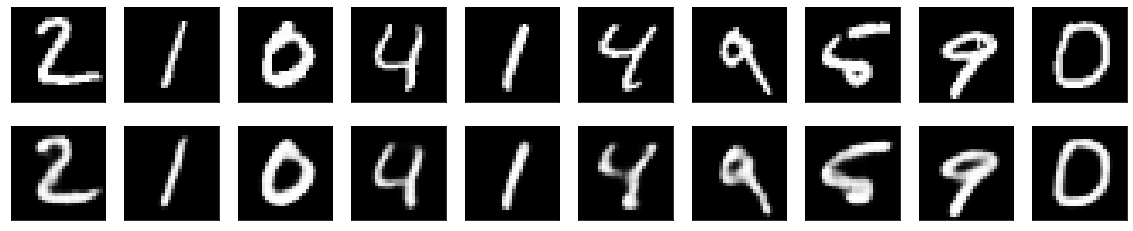

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2. Denoising autoencoder

Generate synthetic noisy digits as follows: apply a gaussian noise matrix and clip the images between 0 and 1.

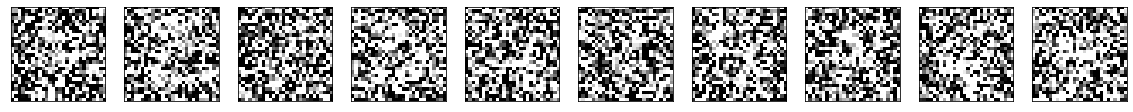

In [ ]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Introduce noise with a probability factor of 0.5
noise_factor = 0.5
x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

train_set = tf.data.Dataset.from_tensor_slices(x_train_noisy).batch(256)
originial_set = tf.data.Dataset.from_tensor_slices(x_train).batch(256)

# Plot figures to show what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Dense Layer 1

In [ ]:
input_img = tf.keras.Input(shape=(28,28,1))
flattened = tf.keras.layers.Flatten()(input_img)
encoded = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(flattened)
encoded = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(encoded)

decoded = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(encoded)
decoded = tf.keras.layers.Dense(units=784, activation=tf.nn.sigmoid)(decoded)
decoded = tf.keras.layers.Reshape((28,28,1))(decoded)

autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/20
235/235 [==============================] - 2s 4ms/step - loss: 0.3294 - val_loss: 0.2389
Epoch 2/20
235/235 [==============================] - 1s 3ms/step - loss: 0.2290 - val_loss: 0.2097
Epoch 3/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2075 - val_loss: 0.2009
Epoch 4/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1986 - val_loss: 0.1928
Epoch 5/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1918 - val_loss: 0.1883
Epoch 6/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1874 - val_loss: 0.1839
Epoch 7/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1832 - val_loss: 0.1817
Epoch 8/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1798 - val_loss: 0.1789
Epoch 9/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1780 - val_loss: 0.1765
Epoch 10/20
235/235 [==============================] - 1s 3ms/step - loss: 0.1756 - val_loss: 0.1752

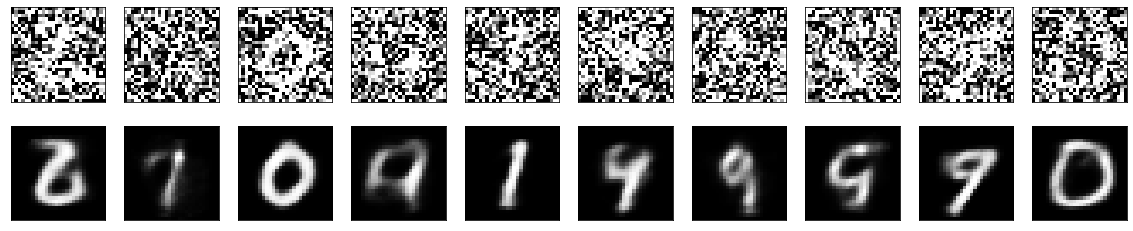

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Dense Layer 2

In [ ]:
input_img = tf.keras.Input(shape=(28,28,1))
flattened = tf.keras.layers.Flatten()(input_img)
encoded = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(flattened)
encoded = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)(encoded)
encoded = tf.keras.layers.Dense(units=32, activation=tf.nn.relu)(encoded)

decoded = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)(encoded)
decoded = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(decoded)
decoded = tf.keras.layers.Dense(units=784, activation=tf.nn.sigmoid)(decoded)
decoded = tf.keras.layers.Reshape((28,28,1))(decoded)

autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/20
235/235 [==============================] - 1s 4ms/step - loss: 0.3347 - val_loss: 0.2488
Epoch 2/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2469 - val_loss: 0.2316
Epoch 3/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2247 - val_loss: 0.2105
Epoch 4/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2079 - val_loss: 0.2022
Epoch 5/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2019 - val_loss: 0.2006
Epoch 6/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1984 - val_loss: 0.1972
Epoch 7/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1946 - val_loss: 0.1928
Epoch 8/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1913 - val_loss: 0.1911
Epoch 9/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1893 - val_loss: 0.1895
Epoch 10/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1872 - val_loss: 0.1863

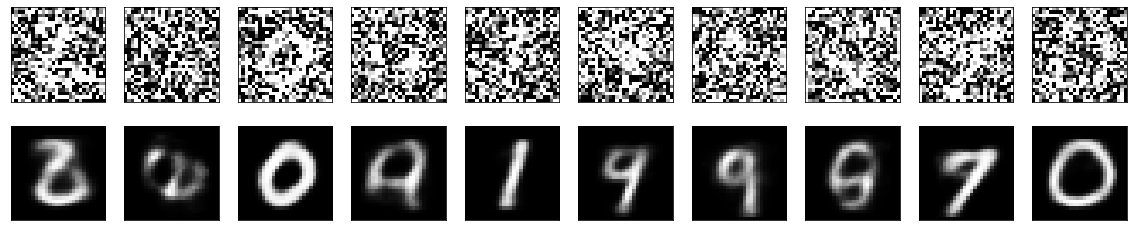

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Dense Layer 3

In [ ]:
input_img = tf.keras.Input(shape=(28,28,1))
flattened = tf.keras.layers.Flatten()(input_img)
encoded = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(flattened)
encoded = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)(encoded)
encoded = tf.keras.layers.Dense(units=32, activation=tf.nn.relu, activity_regularizer = tf.keras.regularizers.l1(10e-5))(encoded)

decoded = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)(encoded)
decoded = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(decoded)
decoded = tf.keras.layers.Dense(units=784, activation=tf.nn.sigmoid)(decoded)
decoded = tf.keras.layers.Reshape((28,28,1))(decoded)

autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/20
235/235 [==============================] - 2s 5ms/step - loss: 0.3404 - val_loss: 0.2507
Epoch 2/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2490 - val_loss: 0.2383
Epoch 3/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2348 - val_loss: 0.2218
Epoch 4/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2202 - val_loss: 0.2127
Epoch 5/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2112 - val_loss: 0.2032
Epoch 6/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2026 - val_loss: 0.1981
Epoch 7/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1963 - val_loss: 0.1949
Epoch 8/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1934 - val_loss: 0.1924
Epoch 9/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1898 - val_loss: 0.1905
Epoch 10/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1871 - val_loss: 0.1888

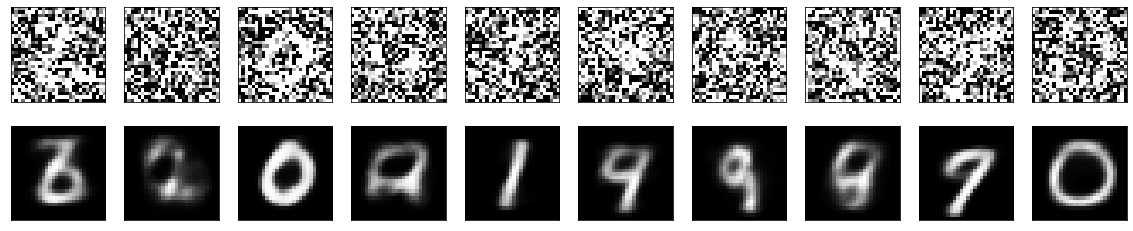

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

CNN architecture

In [ ]:
input_img = tf.keras.Input(shape=(28, 28, 1))

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/20
469/469 [==============================] - 6s 8ms/step - loss: 0.2937 - val_loss: 0.1916
Epoch 2/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1905 - val_loss: 0.1831
Epoch 3/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1823 - val_loss: 0.1795
Epoch 4/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1777 - val_loss: 0.1745
Epoch 5/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1747 - val_loss: 0.1716
Epoch 6/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1728 - val_loss: 0.1706
Epoch 7/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1716 - val_loss: 0.1694
Epoch 8/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1703 - val_loss: 0.1693
Epoch 9/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1694 - val_loss: 0.1687
Epoch 10/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1692 - val_loss: 0.1672

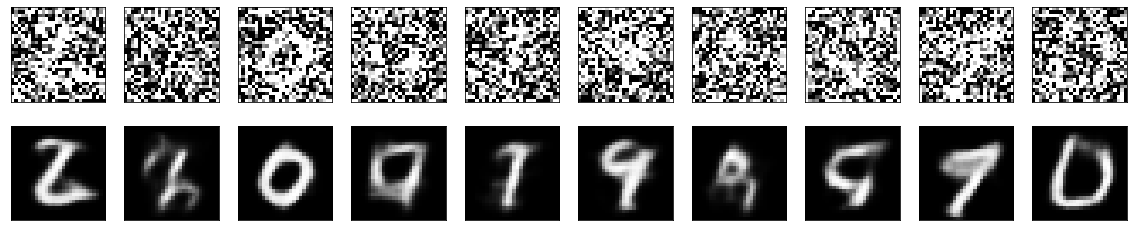

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

CNN architecture with Regularizer L1:

In [ ]:
input_img = tf.keras.Input(shape=(28, 28, 1))

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer =tf.keras.regularizers.l1( l=10e-5))(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer =tf.keras.regularizers.l1( l=10e-5))(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/20
469/469 [==============================] - 4s 8ms/step - loss: 0.3230 - val_loss: 0.2125
Epoch 2/20
469/469 [==============================] - 3s 7ms/step - loss: 0.2095 - val_loss: 0.1970
Epoch 3/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1972 - val_loss: 0.1905
Epoch 4/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1913 - val_loss: 0.1866
Epoch 5/20
469/469 [==============================] - 4s 7ms/step - loss: 0.1881 - val_loss: 0.1889
Epoch 6/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1855 - val_loss: 0.1828
Epoch 7/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1832 - val_loss: 0.1816
Epoch 8/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1816 - val_loss: 0.1783
Epoch 9/20
469/469 [==============================] - 4s 7ms/step - loss: 0.1799 - val_loss: 0.1778
Epoch 10/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1787 - val_loss: 0.1764

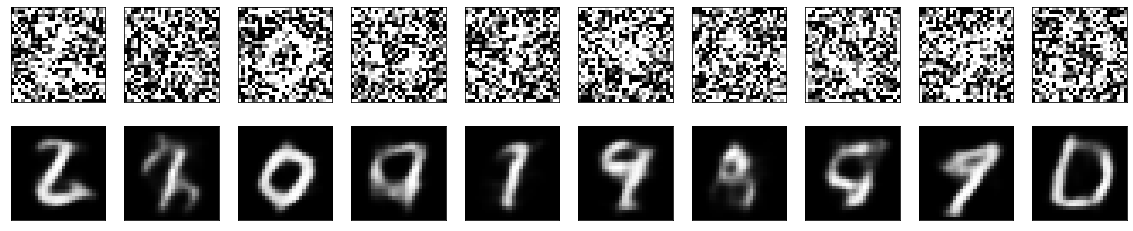

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

CNN architecture with Regularizer L2:

In [ ]:
input_img = tf.keras.Input(shape=(28, 28, 1))

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer =tf.keras.regularizers.l2( l=10e-5))(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer =tf.keras.regularizers.l2( l=10e-5))(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/20
469/469 [==============================] - 4s 8ms/step - loss: 0.2956 - val_loss: 0.1976
Epoch 2/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1945 - val_loss: 0.1881
Epoch 3/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1867 - val_loss: 0.1816
Epoch 4/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1826 - val_loss: 0.1787
Epoch 5/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1796 - val_loss: 0.1768
Epoch 6/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1777 - val_loss: 0.1745
Epoch 7/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1757 - val_loss: 0.1738
Epoch 8/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1740 - val_loss: 0.1727
Epoch 9/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1731 - val_loss: 0.1707
Epoch 10/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1718 - val_loss: 0.1702

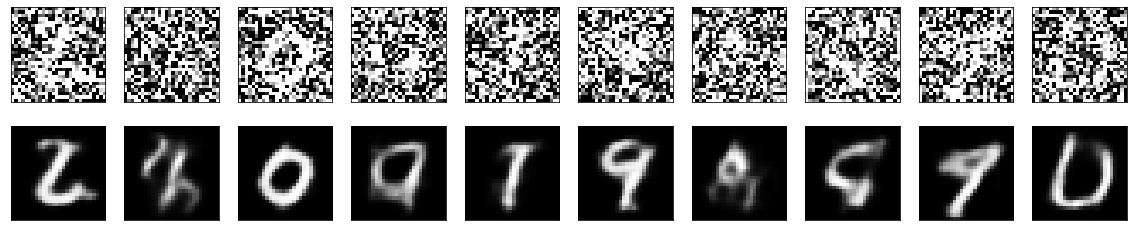

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

CNN architecture with extra convultion layer:

In [ ]:
input_img = tf.keras.Input(shape=(28, 28, 1))

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same',kernel_regularizer = tf.keras.regularizers.l2( l=10e-5))(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same',kernel_regularizer = tf.keras.regularizers.l2( l=10e-5))(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same',kernel_regularizer =tf.keras.regularizers.l2( l=10e-5))(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/20
469/469 [==============================] - 12s 7ms/step - loss: 0.3523 - val_loss: 0.2574
Epoch 2/20
469/469 [==============================] - 3s 6ms/step - loss: 0.2507 - val_loss: 0.2337
Epoch 3/20
469/469 [==============================] - 3s 6ms/step - loss: 0.2300 - val_loss: 0.2205
Epoch 4/20
469/469 [==============================] - 3s 6ms/step - loss: 0.2191 - val_loss: 0.2131
Epoch 5/20
469/469 [==============================] - 3s 6ms/step - loss: 0.2134 - val_loss: 0.2099
Epoch 6/20
469/469 [==============================] - 3s 6ms/step - loss: 0.2093 - val_loss: 0.2064
Epoch 7/20
469/469 [==============================] - 3s 6ms/step - loss: 0.2059 - val_loss: 0.2035
Epoch 8/20
469/469 [==============================] - 3s 6ms/step - loss: 0.2043 - val_loss: 0.2016
Epoch 9/20
469/469 [==============================] - 3s 6ms/step - loss: 0.2024 - val_loss: 0.1994
Epoch 10/20
469/469 [==============================] - 3s 6ms/step - loss: 0.2004 - val_loss: 0.199

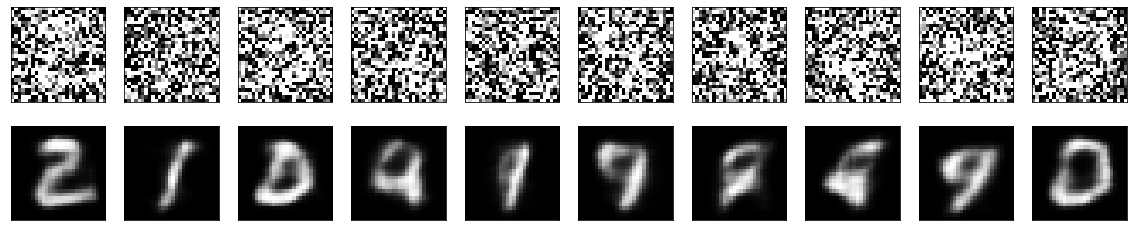

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 3. Text Reconstruction Application

In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import os
from pathlib import Path
import tensorflow as tf
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input, Reshape
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split
np.random.seed(111)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

In [21]:
!wget https://github.com/gmprovan/CS6421-Assignment1/raw/master/train.zip
!unzip train.zip
!wget https://github.com/gmprovan/CS6421-Assignment1/raw/master/train_cleaned.zip
!unzip train_cleaned.zip
!wget https://github.com/gmprovan/CS6421-Assignment1/raw/master/test.zip
!unzip test.zip

--2021-04-14 14:36:26--  https://github.com/gmprovan/CS6421-Assignment1/raw/master/train.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gmprovan/CS6421-Assignment1/master/train.zip [following]
--2021-04-14 14:36:27--  https://raw.githubusercontent.com/gmprovan/CS6421-Assignment1/master/train.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19407030 (19M) [application/zip]
Saving to: ‘train.zip.1’

train.zip.1         100%[===================>]  18.51M  --.-KB/s    in 0.09s   

2021-04-14 14:36:27 (215 MB/s) - ‘train.zip.1’ saved [19407030/19407030]

Archive:  train.zip
replace train/101.

## Data Preprocessing

In [22]:
train = 'train'
train_images = os.listdir(train)
train_cleaned = 'train_cleaned'
train_labels = os.listdir(train_cleaned)

X = []
Y = []

for img in train_images:
    img = load_img(os.path.join(train,img), grayscale=True,target_size=(420,540))
    #img = load_img(train / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(os.path.join(train_cleaned,img), grayscale=True,target_size=(420,540))
    #img = load_img(train_cleaned / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)

# Split the dataset into training and validation. Always set the random state!!
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)
Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)


## Dense Layer Architecture 1: Intermediate layer dimension: 256

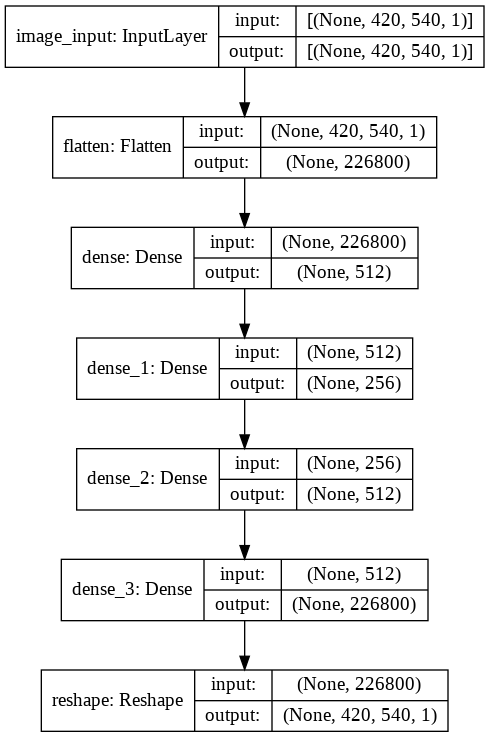

In [ ]:
def build_autoencoder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #encoder 
    encoder = tf.keras.layers.Flatten()(input_img)
    encoder = tf.keras.layers.Dense(units = 512, activation = tf.nn.relu)(encoder)
    encoder = tf.keras.layers.Dense(units = 256, activation = tf.nn.relu)(encoder)

    # Decoder
    decoder = tf.keras.layers.Dense(units = 512, activation = tf.nn.relu)(encoder)
    decoder = tf.keras.layers.Dense(units = 420*540, activation = tf.nn.sigmoid)(decoder)
    decoder = tf.keras.layers.Reshape((420,540,1))(decoder)
    
    #model
    autoencoder = Model(input_img,decoder)
    autoencoder.compile(optimizer='Adam', loss='binary_crossentropy',metrics=tf.metrics.RootMeanSquaredError())
    return autoencoder
autoencoder_dense_1 = build_autoencoder()
tf.keras.utils.plot_model(autoencoder_dense_1, "autoencoder_dense_1.png", show_shapes=True)

In [ ]:
# Model Training
history_autoencoder_dense_1 = autoencoder_dense_1.fit(X_train, y_train, epochs=100, batch_size=8,
                validation_data=(X_valid, y_valid))

Epoch 1/100
17/17 [==============================] - 3s 88ms/step - loss: 0.4919 - root_mean_squared_error: 0.3473 - val_loss: 0.3437 - val_root_mean_squared_error: 0.2666
Epoch 2/100
17/17 [==============================] - 1s 62ms/step - loss: 0.3315 - root_mean_squared_error: 0.2626 - val_loss: 0.3080 - val_root_mean_squared_error: 0.2520
Epoch 3/100
17/17 [==============================] - 1s 63ms/step - loss: 0.2958 - root_mean_squared_error: 0.2477 - val_loss: 0.2888 - val_root_mean_squared_error: 0.2475
Epoch 4/100
17/17 [==============================] - 1s 63ms/step - loss: 0.2762 - root_mean_squared_error: 0.2408 - val_loss: 0.2532 - val_root_mean_squared_error: 0.2286
Epoch 5/100
17/17 [==============================] - 1s 62ms/step - loss: 0.2498 - root_mean_squared_error: 0.2263 - val_loss: 0.2535 - val_root_mean_squared_error: 0.2287
Epoch 6/100
17/17 [==============================] - 1s 62ms/step - loss: 0.2506 - root_mean_squared_error: 0.2295 - val_loss: 0.2536 - val_

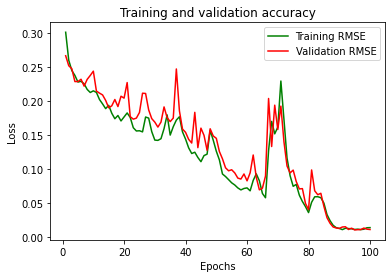

In [42]:
train_rmse = history_autoencoder_dense_1.history['root_mean_squared_error']
val_rmse = history_autoencoder_dense_1.history['val_root_mean_squared_error']
epochs = range(1, len(train_rmse)+1)

plt.plot(epochs, train_rmse, 'g', label='Training RMSE')
plt.plot(epochs, val_rmse, 'r', label='Validation RMSE')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

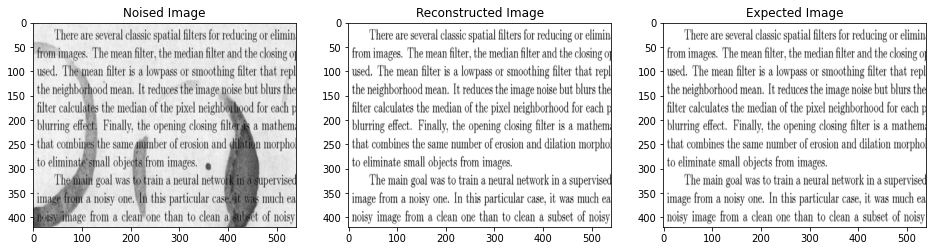

In [ ]:
# Compute the prediction
predicted_label = np.squeeze(autoencoder_dense_1.predict(X_valid))

f, ax = plt.subplots(1,3, figsize=(16,8))
ax[0].imshow(np.squeeze(X_valid[0]), cmap='gray')
ax[0].set_title('Noised Image')
ax[1].imshow(np.squeeze(predicted_label[0]), cmap='gray')
ax[1].set_title('Reconstructed Image')
ax[2].imshow(np.squeeze(y_valid[0]), cmap='gray')
ax[2].set_title('Expected Image')
plt.show()

## Dense Layer Architecture 2: Multi Layered Architecture

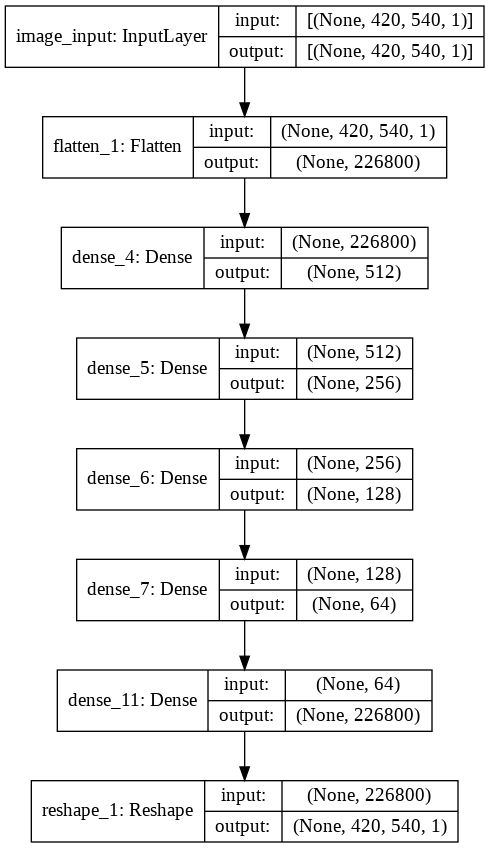

In [ ]:
def build_autoencoder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #encoder 
    encoder = tf.keras.layers.Flatten()(input_img)
    encoder = tf.keras.layers.Dense(units = 512, activation = tf.nn.relu)(encoder)
    encoder = tf.keras.layers.Dense(units = 256, activation = tf.nn.relu)(encoder)
    encoder = tf.keras.layers.Dense(units = 128, activation = tf.nn.relu)(encoder)
    encoder = tf.keras.layers.Dense(units = 64, activation = tf.nn.relu)(encoder)

    # Decoder
    decoder = tf.keras.layers.Dense(units = 128, activation = tf.nn.relu)(encoder)
    decoder = tf.keras.layers.Dense(units = 256, activation = tf.nn.relu)(encoder)
    decoder = tf.keras.layers.Dense(units = 512, activation = tf.nn.relu)(encoder)
    decoder = tf.keras.layers.Dense(units = 420*540, activation = tf.nn.sigmoid)(encoder)
    decoder = tf.keras.layers.Reshape((420,540,1))(decoder)
    
    #model
    autoencoder = Model(input_img,decoder)
    autoencoder.compile(optimizer='Adam', loss='binary_crossentropy',metrics=tf.metrics.RootMeanSquaredError())
    return autoencoder
autoencoder_dense_2 = build_autoencoder()
tf.keras.utils.plot_model(autoencoder_dense_2, "autoencoder_dense_2.png", show_shapes=True)

In [ ]:
# Model Training
history_autoencoder_dense_2 = autoencoder_dense_2.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_valid, y_valid))

Epoch 1/100
17/17 [==============================] - 1s 49ms/step - loss: 0.4874 - root_mean_squared_error: 0.3557 - val_loss: 0.3214 - val_root_mean_squared_error: 0.2596
Epoch 2/100
17/17 [==============================] - 1s 40ms/step - loss: 0.3220 - root_mean_squared_error: 0.2603 - val_loss: 0.3179 - val_root_mean_squared_error: 0.2572
Epoch 3/100
17/17 [==============================] - 1s 40ms/step - loss: 0.3142 - root_mean_squared_error: 0.2539 - val_loss: 0.2990 - val_root_mean_squared_error: 0.2483
Epoch 4/100
17/17 [==============================] - 1s 39ms/step - loss: 0.2824 - root_mean_squared_error: 0.2410 - val_loss: 0.2805 - val_root_mean_squared_error: 0.2437
Epoch 5/100
17/17 [==============================] - 1s 40ms/step - loss: 0.2632 - root_mean_squared_error: 0.2339 - val_loss: 0.2556 - val_root_mean_squared_error: 0.2299
Epoch 6/100
17/17 [==============================] - 1s 39ms/step - loss: 0.2496 - root_mean_squared_error: 0.2268 - val_loss: 0.2772 - val_

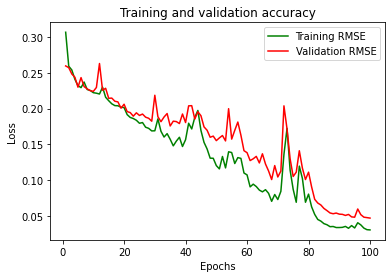

In [41]:
train_rmse = history_autoencoder_dense_2.history['root_mean_squared_error']
val_rmse = history_autoencoder_dense_2.history['val_root_mean_squared_error']
epochs = range(1, len(train_rmse)+1)

plt.plot(epochs, train_rmse, 'g', label='Training RMSE')
plt.plot(epochs, val_rmse, 'r', label='Validation RMSE')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

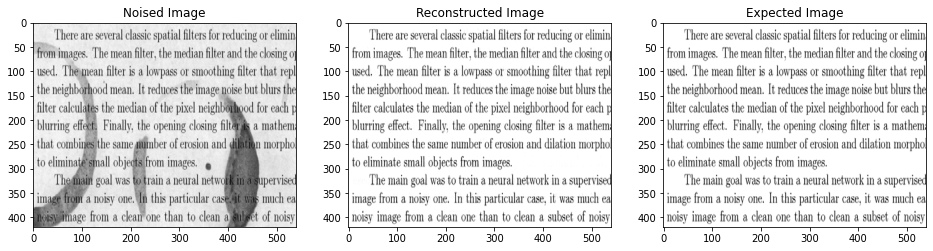

In [ ]:
# Compute the prediction
predicted_label = np.squeeze(autoencoder_dense_2.predict(X_valid))

f, ax = plt.subplots(1,3, figsize=(16,8))
ax[0].imshow(np.squeeze(X_valid[0]), cmap='gray')
ax[0].set_title('Noised Image')
ax[1].imshow(np.squeeze(predicted_label[0]), cmap='gray')
ax[1].set_title('Reconstructed Image')
ax[2].imshow(np.squeeze(y_valid[0]), cmap='gray')
ax[2].set_title('Expected Image')
plt.show()

## CNN Architecture

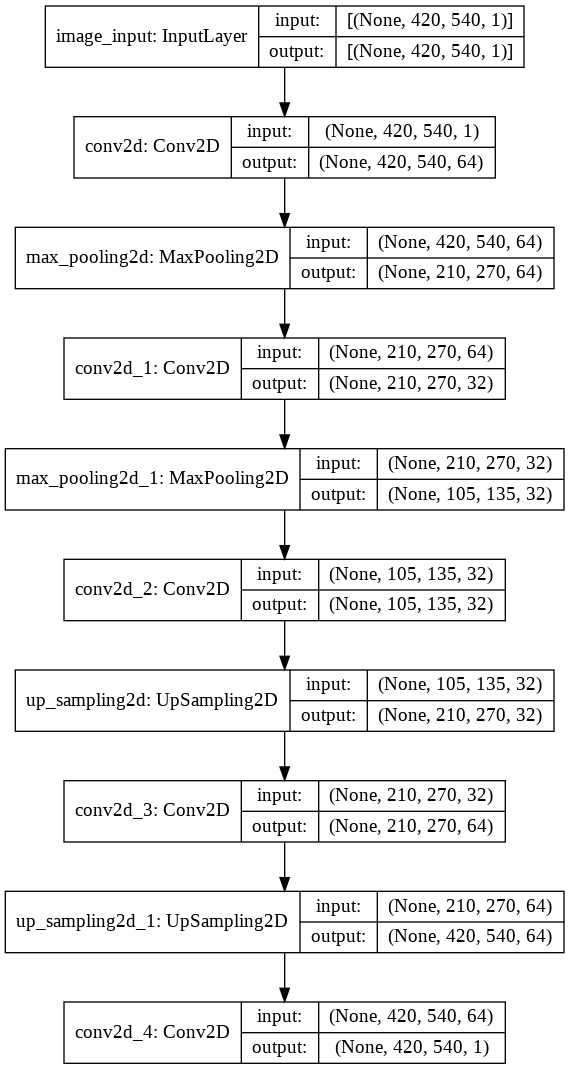

In [ ]:
# Lets' define our autoencoder now
def build_autoencoder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #encoder 
    # input_img = tf.keras.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = tf.keras.layers.MaxPooling2D((2,2), padding='same')(x)

    #decoder
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = tf.keras.layers.UpSampling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    #model
    autoencoder = Model(input_img,decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics=tf.metrics.RootMeanSquaredError())
    return autoencoder
autoencoder_CNN = build_autoencoder()
tf.keras.utils.plot_model(autoencoder_CNN, "autoencoder_CNN.png", show_shapes=True)

In [ ]:
# Model Training
history_autoencoder_CNN = autoencoder_CNN.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_valid, y_valid))

Epoch 1/100
17/17 [==============================] - 8s 226ms/step - loss: 0.5293 - root_mean_squared_error: 0.3780 - val_loss: 0.3621 - val_root_mean_squared_error: 0.2740
Epoch 2/100
17/17 [==============================] - 2s 130ms/step - loss: 0.3491 - root_mean_squared_error: 0.2687 - val_loss: 0.3068 - val_root_mean_squared_error: 0.2509
Epoch 3/100
17/17 [==============================] - 2s 131ms/step - loss: 0.2886 - root_mean_squared_error: 0.2424 - val_loss: 0.2438 - val_root_mean_squared_error: 0.2288
Epoch 4/100
17/17 [==============================] - 2s 131ms/step - loss: 0.2400 - root_mean_squared_error: 0.2261 - val_loss: 0.2257 - val_root_mean_squared_error: 0.2159
Epoch 5/100
17/17 [==============================] - 2s 131ms/step - loss: 0.2197 - root_mean_squared_error: 0.2127 - val_loss: 0.2116 - val_root_mean_squared_error: 0.2067
Epoch 6/100
17/17 [==============================] - 2s 132ms/step - loss: 0.2082 - root_mean_squared_error: 0.2024 - val_loss: 0.1977 

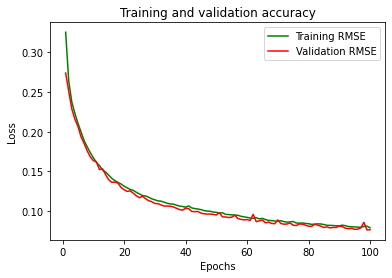

In [40]:
train_rmse = history_autoencoder_CNN.history['root_mean_squared_error']
val_rmse = history_autoencoder_CNN.history['val_root_mean_squared_error']
epochs = range(1, len(train_rmse)+1)

plt.plot(epochs, train_rmse, 'g', label='Training RMSE')
plt.plot(epochs, val_rmse, 'r', label='Validation RMSE')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

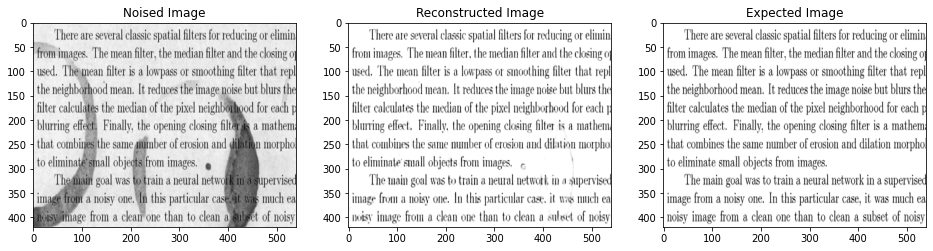

In [ ]:
# Compute the prediction
predicted_label = np.squeeze(autoencoder_CNN.predict(X_valid))

f, ax = plt.subplots(1,3, figsize=(16,8))
ax[0].imshow(np.squeeze(X_valid[0]), cmap='gray')
ax[0].set_title('Noised Image')
ax[1].imshow(np.squeeze(predicted_label[0]), cmap='gray')
ax[1].set_title('Reconstructed Image')
ax[2].imshow(np.squeeze(y_valid[0]), cmap='gray')
ax[2].set_title('Expected Image')
plt.show()

## CNN Complex Architecture 1:

One Extra layer of convolution layer is added and a maxpooling layer is removed as to preserve the information from relatively large image.

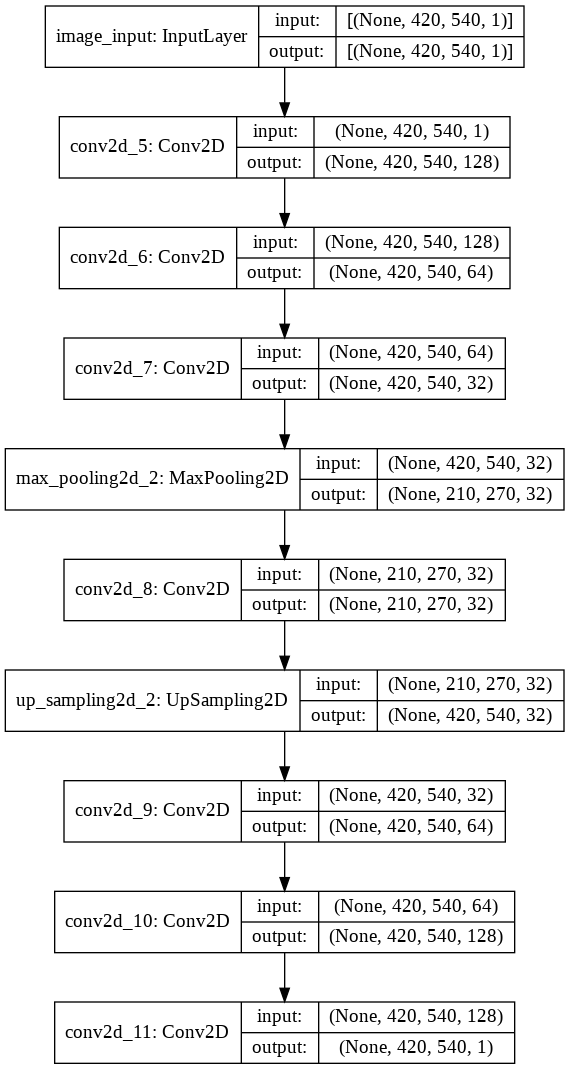

In [ ]:
# Lets' define our autoencoder now
def build_autoencoder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #encoder 
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = tf.keras.layers.MaxPooling2D((2,2), padding='same')(x)

    #decoder
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = tf.keras.layers.UpSampling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    #model
    autoencoder = Model(input_img,decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics=tf.metrics.RootMeanSquaredError())
    return autoencoder
autoencoder_CNN_1 = build_autoencoder()
tf.keras.utils.plot_model(autoencoder_CNN_1, "autoencoder_CNN_1.png", show_shapes=True)

In [ ]:
# Model Training
history_autoencoder_CNN_1 = autoencoder_CNN_1.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_valid, y_valid))

Epoch 1/100
17/17 [==============================] - 30s 1s/step - loss: 0.5394 - root_mean_squared_error: 0.3864 - val_loss: 0.3130 - val_root_mean_squared_error: 0.2549
Epoch 2/100
17/17 [==============================] - 10s 592ms/step - loss: 0.3132 - root_mean_squared_error: 0.2541 - val_loss: 0.2505 - val_root_mean_squared_error: 0.2221
Epoch 3/100
17/17 [==============================] - 10s 601ms/step - loss: 0.2259 - root_mean_squared_error: 0.2124 - val_loss: 0.1640 - val_root_mean_squared_error: 0.1564
Epoch 4/100
17/17 [==============================] - 10s 610ms/step - loss: 0.1564 - root_mean_squared_error: 0.1427 - val_loss: 0.1312 - val_root_mean_squared_error: 0.1102
Epoch 5/100
17/17 [==============================] - 10s 609ms/step - loss: 0.1287 - root_mean_squared_error: 0.1079 - val_loss: 0.1179 - val_root_mean_squared_error: 0.0907
Epoch 6/100
17/17 [==============================] - 10s 606ms/step - loss: 0.1155 - root_mean_squared_error: 0.0891 - val_loss: 0.10

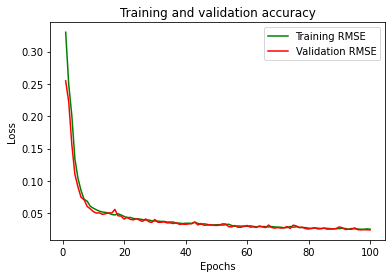

In [39]:
train_rmse = history_autoencoder_CNN_1.history['root_mean_squared_error']
val_rmse = history_autoencoder_CNN_1.history['val_root_mean_squared_error']
epochs = range(1, len(train_rmse)+1)

plt.plot(epochs, train_rmse, 'g', label='Training RMSE')
plt.plot(epochs, val_rmse, 'r', label='Validation RMSE')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

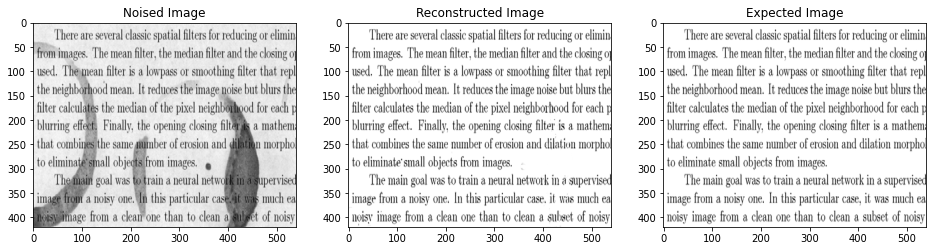

In [ ]:
# Compute the prediction
predicted_label = np.squeeze(autoencoder_CNN_1.predict(X_valid))

f, ax = plt.subplots(1,3, figsize=(16,8))
ax[0].imshow(np.squeeze(X_valid[0]), cmap='gray')
ax[0].set_title('Noised Image')
ax[1].imshow(np.squeeze(predicted_label[0]), cmap='gray')
ax[1].set_title('Reconstructed Image')
ax[2].imshow(np.squeeze(y_valid[0]), cmap='gray')
ax[2].set_title('Expected Image')
plt.show()

## CNN Complex Architecture 2
* Complex Architecture 1 looks bulky and is taking 11s for each epoch.
* Feature map size should be reduced and dropout layers maybe added to decrease computational complexity 

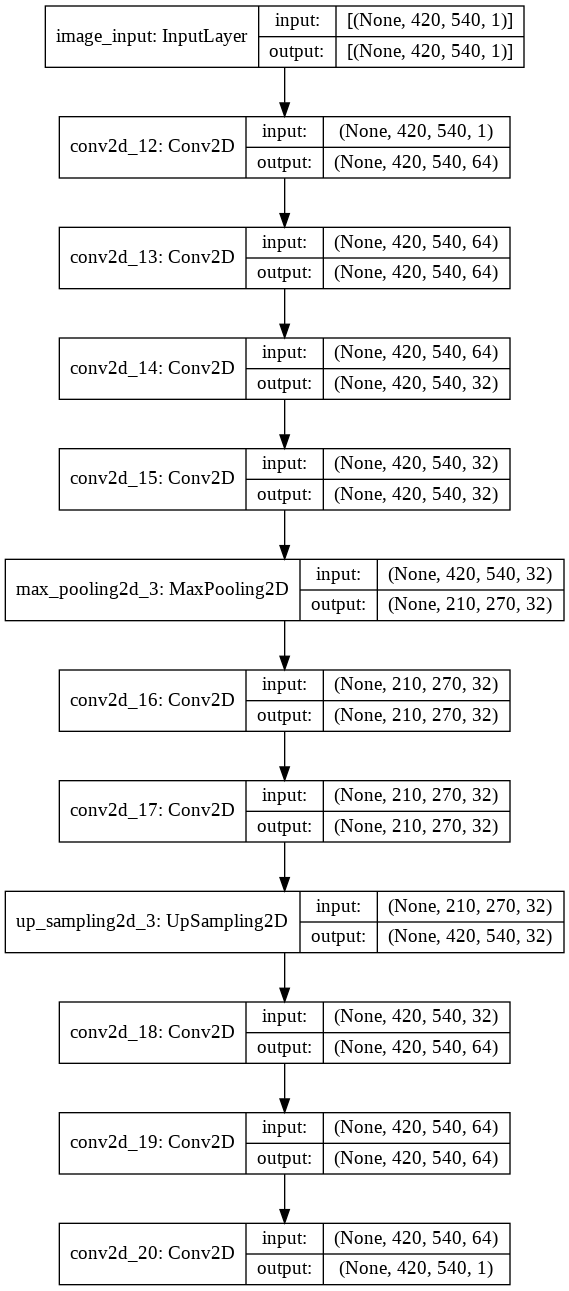

In [23]:
# Lets' define our autoencoder now
def build_autoencoder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #encoder 
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = tf.keras.layers.MaxPooling2D((2,2), padding='same')(x)

    #decoder
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    #model
    autoencoder = Model(input_img,decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics=tf.metrics.RootMeanSquaredError())
    return autoencoder
autoencoder_CNN_2 = build_autoencoder()
tf.keras.utils.plot_model(autoencoder_CNN_2, "autoencoder_CNN_2.png", show_shapes=True)

In [24]:
# Model Training
history_autoencoder_CNN_2 = autoencoder_CNN_2.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_valid, y_valid))

Epoch 1/100
17/17 [==============================] - 14s 582ms/step - loss: 0.5054 - root_mean_squared_error: 0.3644 - val_loss: 0.3259 - val_root_mean_squared_error: 0.2606
Epoch 2/100
17/17 [==============================] - 7s 428ms/step - loss: 0.3220 - root_mean_squared_error: 0.2573 - val_loss: 0.2759 - val_root_mean_squared_error: 0.2410
Epoch 3/100
17/17 [==============================] - 7s 432ms/step - loss: 0.2527 - root_mean_squared_error: 0.2284 - val_loss: 0.1821 - val_root_mean_squared_error: 0.1795
Epoch 4/100
17/17 [==============================] - 7s 436ms/step - loss: 0.1667 - root_mean_squared_error: 0.1603 - val_loss: 0.1599 - val_root_mean_squared_error: 0.1399
Epoch 5/100
17/17 [==============================] - 7s 436ms/step - loss: 0.1409 - root_mean_squared_error: 0.1253 - val_loss: 0.1303 - val_root_mean_squared_error: 0.1106
Epoch 6/100
17/17 [==============================] - 7s 438ms/step - loss: 0.1255 - root_mean_squared_error: 0.1033 - val_loss: 0.1211

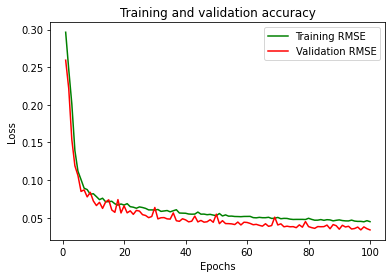

In [38]:
train_rmse = history_autoencoder_CNN_2.history['root_mean_squared_error']
val_rmse = history_autoencoder_CNN_2.history['val_root_mean_squared_error']
epochs = range(1, len(train_rmse)+1)

plt.plot(epochs, train_rmse, 'g', label='Training RMSE')
plt.plot(epochs, val_rmse, 'r', label='Validation RMSE')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

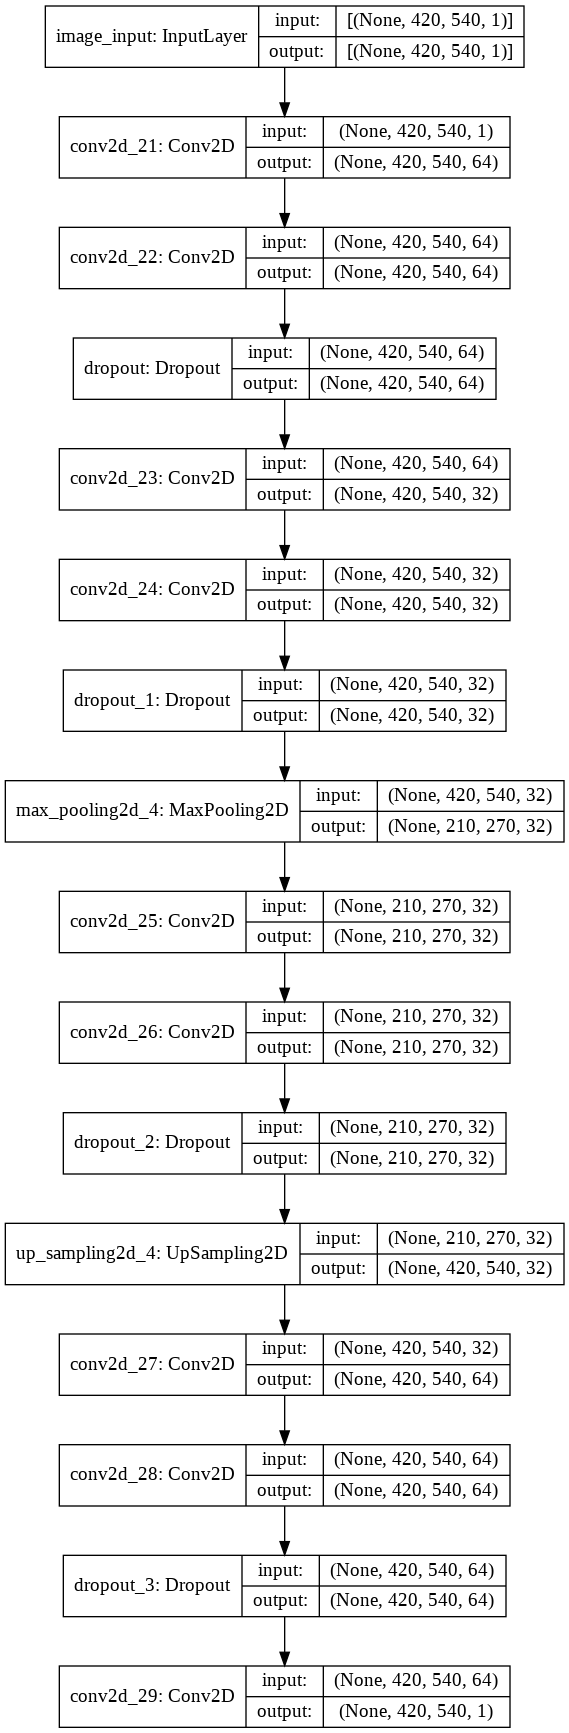

In [26]:
# Lets' define our autoencoder now
def build_autoencoder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #encoder 
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.L1(l1 = 10e-4))(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    encoded = tf.keras.layers.MaxPooling2D((2,2), padding='same')(x)

    #decoder
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.UpSampling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    #model
    autoencoder = Model(input_img,decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics=tf.metrics.RootMeanSquaredError())
    return autoencoder
autoencoder_CNN_2 = build_autoencoder()
tf.keras.utils.plot_model(autoencoder_CNN_2, "autoencoder_CNN_2.png", show_shapes=True)

In [27]:
# Model Training
history_autoencoder_CNN_2 = autoencoder_CNN_2.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_valid, y_valid))

Epoch 1/100
17/17 [==============================] - 10s 529ms/step - loss: 0.9050 - root_mean_squared_error: 0.3380 - val_loss: 0.6952 - val_root_mean_squared_error: 0.2594
Epoch 2/100
17/17 [==============================] - 9s 518ms/step - loss: 0.6471 - root_mean_squared_error: 0.2521 - val_loss: 0.5189 - val_root_mean_squared_error: 0.2217
Epoch 3/100
17/17 [==============================] - 9s 522ms/step - loss: 0.4704 - root_mean_squared_error: 0.2129 - val_loss: 0.3574 - val_root_mean_squared_error: 0.1538
Epoch 4/100
17/17 [==============================] - 9s 523ms/step - loss: 0.3375 - root_mean_squared_error: 0.1467 - val_loss: 0.2724 - val_root_mean_squared_error: 0.1190
Epoch 5/100
17/17 [==============================] - 9s 524ms/step - loss: 0.2557 - root_mean_squared_error: 0.1152 - val_loss: 0.2250 - val_root_mean_squared_error: 0.1060
Epoch 6/100
17/17 [==============================] - 9s 524ms/step - loss: 0.2173 - root_mean_squared_error: 0.1052 - val_loss: 0.1892

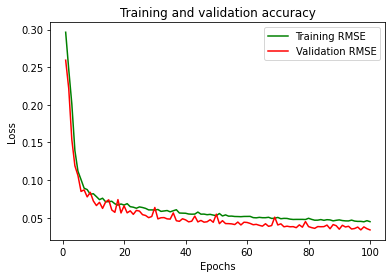

In [37]:
train_rmse = history_autoencoder_CNN_2.history['root_mean_squared_error']
val_rmse = history_autoencoder_CNN_2.history['val_root_mean_squared_error']
epochs = range(1, len(train_rmse)+1)

plt.plot(epochs, train_rmse, 'g', label='Training RMSE')
plt.plot(epochs, val_rmse, 'r', label='Validation RMSE')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

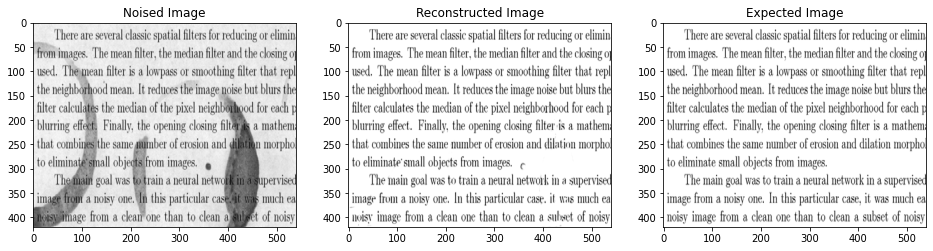

In [29]:
# Compute the prediction
predicted_label = np.squeeze(autoencoder_CNN_2.predict(X_valid))

f, ax = plt.subplots(1,3, figsize=(16,8))
ax[0].imshow(np.squeeze(X_valid[0]), cmap='gray')
ax[0].set_title('Noised Image')
ax[1].imshow(np.squeeze(predicted_label[0]), cmap='gray')
ax[1].set_title('Reconstructed Image')
ax[2].imshow(np.squeeze(y_valid[0]), cmap='gray')
ax[2].set_title('Expected Image')
plt.show()

## CNN Complex Architecture 3
Building a combination of CNN and Dense architecture

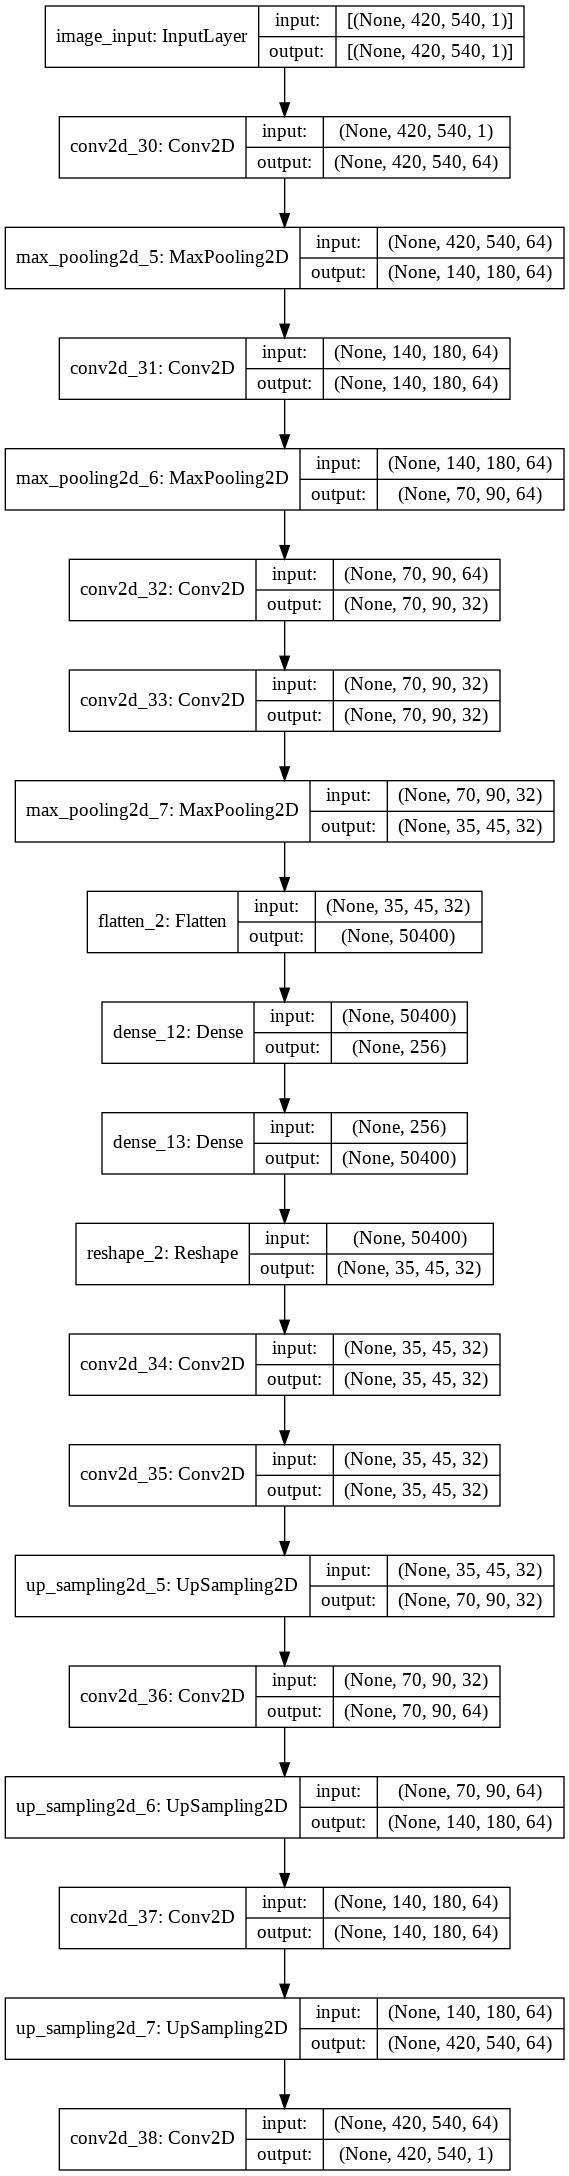

In [30]:
# Lets' define our autoencoder now
def build_autoencoder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #encoder 
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = tf.keras.layers.MaxPooling2D((3,3), padding='same')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2,2), padding='same')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.L1(l1 = 10e-5))(x)
    x = tf.keras.layers.MaxPooling2D((2,2), padding='same')(x)

    # Dense Encoder
    img_size = K.int_shape(x)
    x = Flatten()(x)
    encoded = tf.keras.layers.Dense(256, activation='relu')(x)

    #decoder
    x = tf.keras.layers.Dense(np.prod(img_size[1:]))(encoded)
    x = Reshape((img_size[1], img_size[2], img_size[3]))(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((3,3))(x)
    decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    #model
    autoencoder = Model(input_img,decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics=tf.metrics.RootMeanSquaredError())
    return autoencoder
autoencoder_CNN_3 = build_autoencoder()
tf.keras.utils.plot_model(autoencoder_CNN_3, "autoencoder_CNN_3.png", show_shapes=True)

In [31]:
# Model Training
history_autoencoder_CNN_3 = autoencoder_CNN_3.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_valid, y_valid))

Epoch 1/100
17/17 [==============================] - 5s 192ms/step - loss: 0.6481 - root_mean_squared_error: 0.3820 - val_loss: 0.4047 - val_root_mean_squared_error: 0.2763
Epoch 2/100
17/17 [==============================] - 2s 128ms/step - loss: 0.3965 - root_mean_squared_error: 0.2721 - val_loss: 0.3730 - val_root_mean_squared_error: 0.2623
Epoch 3/100
17/17 [==============================] - 2s 126ms/step - loss: 0.3769 - root_mean_squared_error: 0.2650 - val_loss: 0.3609 - val_root_mean_squared_error: 0.2602
Epoch 4/100
17/17 [==============================] - 2s 127ms/step - loss: 0.3619 - root_mean_squared_error: 0.2609 - val_loss: 0.3572 - val_root_mean_squared_error: 0.2600
Epoch 5/100
17/17 [==============================] - 2s 127ms/step - loss: 0.3605 - root_mean_squared_error: 0.2613 - val_loss: 0.3527 - val_root_mean_squared_error: 0.2593
Epoch 6/100
17/17 [==============================] - 2s 128ms/step - loss: 0.3587 - root_mean_squared_error: 0.2620 - val_loss: 0.3507 

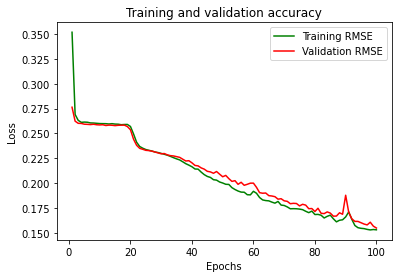

In [36]:
train_rmse = history_autoencoder_CNN_3.history['root_mean_squared_error']
val_rmse = history_autoencoder_CNN_3.history['val_root_mean_squared_error']
epochs = range(1, len(train_rmse)+1)

plt.plot(epochs, train_rmse, 'g', label='Training RMSE')
plt.plot(epochs, val_rmse, 'r', label='Validation RMSE')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Denoising Test Images

In [33]:
test = 'test'
test_images = os.listdir(test)
X_test = []
for img in test_images:
    img = load_img(os.path.join(test,img), grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X_test.append(img)

X_test = np.array(X_test)

print("Size of X_test : ", X_test.shape)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Size of X_test :  (72, 420, 540, 1)


Text(0.5, 1.0, 'Reconstructed Image')

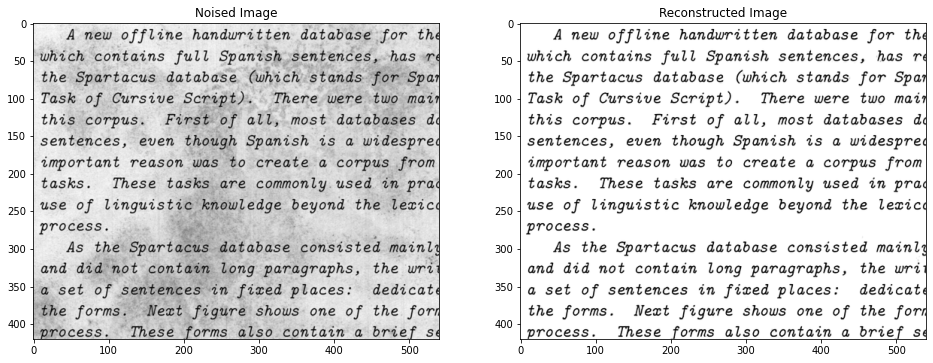

In [34]:
denoised_images = np.squeeze(autoencoder_CNN_2.predict(X_test))

f, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].imshow(np.squeeze(X_test[0]), cmap='gray')
ax[0].set_title('Noised Image')
ax[1].imshow(np.squeeze(denoised_images[0]), cmap='gray')
ax[1].set_title('Reconstructed Image')

Text(0.5, 1.0, 'Reconstructed Image')

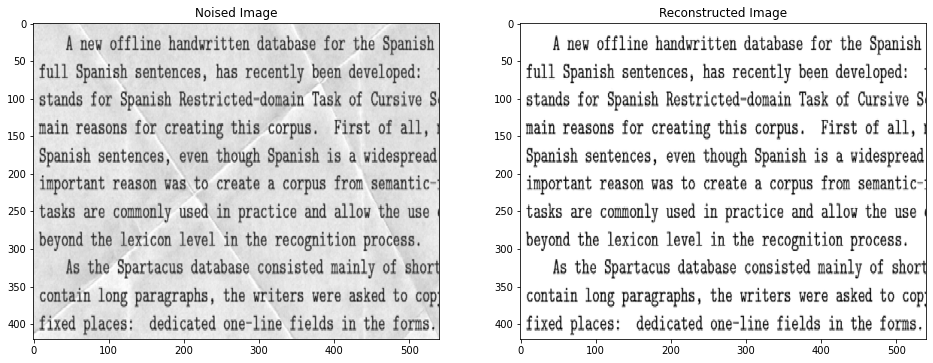

In [35]:
denoised_images = np.squeeze(autoencoder_CNN_1.predict(X_test))

f, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].imshow(np.squeeze(X_test[51]), cmap='gray')
ax[0].set_title('Noised Image')
ax[1].imshow(np.squeeze(denoised_images[51]), cmap='gray')
ax[1].set_title('Reconstructed Image')

# Summary Report:
#### Dataset Information:
*   Image Size: 420 x 540 grayscale
*   Training samples: 129 (90%)
*   Validation samples: 15 (10%)

***
#### Model Architecture 1: Dense Layers
Encoder: 
* 2 layered Dense layer was used with ReLU as activation function
* Shape of Input to Encoder: 420x540 pixels
* Shape of Output of Encoder: 256x1 pixel array
* Decode Output shape: 420x540 pixels
* Sigmoid activation is used to add more non linearity to the model
* Loss measure: binary cross entropy
* Metrics: RMSE

Average Execution time / epoch: 1s
Final validation loss occured at 100 epochs: 0.01

`Final RMSE achieved at 100 epochs: 0.1`

***
#### Model Architecture 2: Deeper Dense Layers
* 4 Layered dense encoding was used
* Regularization such as MaxPooling was not used

`Final RMSE achieved at 100 epochs: 0.13 (No Improvements)`

***
#### Model Architecture 3: CNN Architecture
* 2 layered convolution architecture was used for both encoder and decoder network

`Conv Layer 1: 64 feature maps, 3x3 kernel size and ReLU activation function`

`Conv Layer 2: 32 feature maps, 3x3 kernel size and ReLU activation function`

`Final RMSE achieved at 100 epochs: 0.07`

***

#### Model Architecture 4: CNN Complex Architecture 1
* One Extra layer of convolution layer is added and a maxpooling layer is removed as to preserve the information from relatively large image.

`Conv Layer 1: 128 feature maps, 3x3 kernel size and ReLU activation function`

`Conv Layer 2: 64 feature maps, 3x3 kernel size and ReLU activation function`

`Conv Layer 3: 32 feature maps, 3x3 kernel size and ReLU activation function`

`Final RMSE achieved at 100 epochs: 0.02`
***
#### Model Architecture 5: CNN Complex Architecture 2
* Complex Architecture looked bulky and was taking 11s for each epoch.
* Feature map size was reduced and dropout layers were added to decreasse computational complexity 

`Conv Layer 1: 64 feature maps, 3x3 kernel size and ReLU activation function`

`Conv Layer 2: 64 feature maps, 3x3 kernel size and ReLU activation function`

`Conv Layer 3: 32 feature maps, 3x3 kernel size and ReLU activation function`

`Conv Layer 4: 32 feature maps, 3x3 kernel size and ReLU activation function`

`Final RMSE achieved at 100 epochs: 0.03`
***
#### Model Architecture 6: CNN Complex Architecture 3
* Combine Dense and CNN architectures 
* Dense layer with 256 units was introduced to encoder.
* Furthur Maxpool layers were used to reduce the complexity
* A reshape layer was used to reshape back the encoded image

`Conv Layer 1: 64 feature maps, 3x3 kernel size and ReLU activation function`

`Conv Layer 2: 64 feature maps, 3x3 kernel size and ReLU activation function`

`Conv Layer 3: 32 feature maps, 3x3 kernel size and ReLU activation function`

`Conv Layer 4: 32 feature maps, 3x3 kernel size and ReLU activation function`

`Dense Layer: 256 units and ReLU activation function`

`Final RMSE achieved at 100 epochs: 0.15`

`Loss seemed to be very when compared to other architectures. This is due to the fact that we used multiple maxpool layer (even 3x3 Maxpool layer was used) which resulted in increase in loss. Furthur the dense layer compressed the image to the scale of 256 which resulting in more loss of information`

**Improvements:** 
1. We could use batch normalisation technique that allows every layer of the network to do learning more independently. 
2. EarlyStopping: Trigger Early stopping once the model stops learning.
3. Use improved activation functions and regularizers